In [24]:
# ! pip install -q kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d jonathansilva2020/orange-diseases-dataset
# !unzip orange-diseases-dataset.zip

In [25]:
# Data Cleaning
# Data Augmentation
# Model Building using CNN
# localhost on GCP

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras import models, layers

In [27]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 50

In [28]:
train = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/dataset/train',
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

test = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/dataset/test',
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1164 files belonging to 4 classes.
Found 626 files belonging to 4 classes.


In [29]:
class_names = train.class_names
class_names

['blackspot', 'canker', 'fresh', 'grenning']

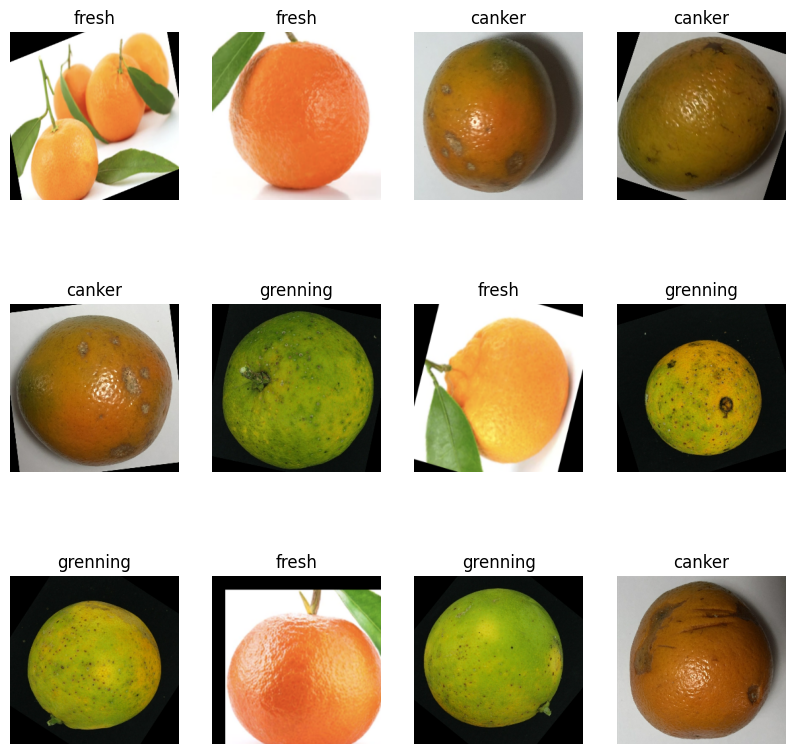

In [30]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in train.take(1):
  for i in range(12):
    ax = plt.subplot(3,4,i+1)
    plt.imshow(image_batch[i].numpy().astype('uint8'))
    plt.title(class_names[label_batch[i]])
    plt.axis('off')
    #print(image_batch[0].shape)
  #print(label_batch.numpy())
  #print(len(label_batch.numpy()))

In [31]:
train_size = 0.8
train_ds = train.take(30)
val_ds = train.skip(30)
print(len(train_ds), len(val_ds))

30 7


In [32]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [33]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [34]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [35]:
n_classes = len(class_names)
CHANNELS = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation='relu', input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')
])

model.build(input_shape=(BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))


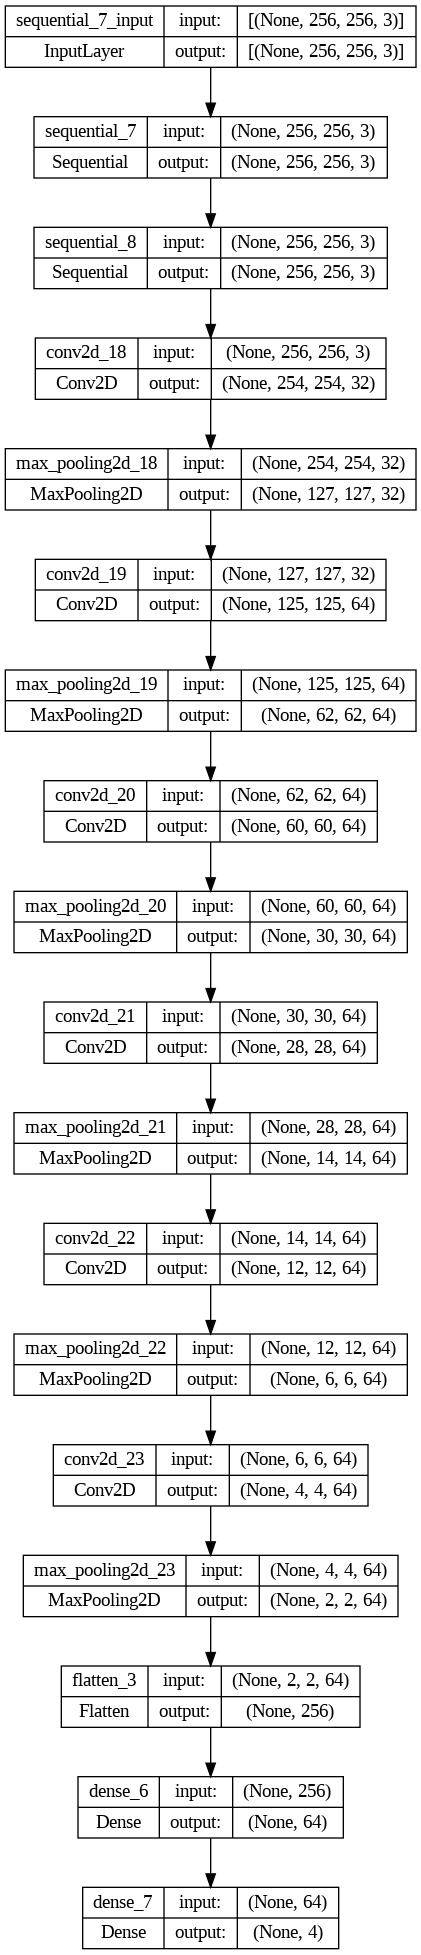

In [57]:
tf.keras.utils.plot_model(model, to_file='model_diagram.png', show_shapes=True)

In [36]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_7 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_8 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_18 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_18 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_19 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_19 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [37]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [38]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
30/30 [==============================] - 24s 240ms/step - loss: 0.6989 - accuracy: 0.6729 - val_loss: 0.2913 - val_accuracy: 0.8284
Epoch 2/50
30/30 [==============================] - 2s 68ms/step - loss: 0.2558 - accuracy: 0.8594 - val_loss: 0.2385 - val_accuracy: 0.8725
Epoch 3/50
30/30 [==============================] - 2s 62ms/step - loss: 0.2404 - accuracy: 0.8760 - val_loss: 0.2886 - val_accuracy: 0.8333
Epoch 4/50
30/30 [==============================] - 2s 62ms/step - loss: 0.2311 - accuracy: 0.8687 - val_loss: 0.1824 - val_accuracy: 0.9118
Epoch 5/50
30/30 [==============================] - 2s 62ms/step - loss: 0.2146 - accuracy: 0.8958 - val_loss: 0.2254 - val_accuracy: 0.8775
Epoch 6/50
30/30 [==============================] - 2s 62ms/step - loss: 0.2121 - accuracy: 0.9021 - val_loss: 0.1853 - val_accuracy: 0.9118
Epoch 7/50
30/30 [==============================] - 2s 66ms/step - loss: 0.1828 - accuracy: 0.9229 - val_loss: 0.2076 - val_accuracy: 0.8971
Epoch 8/50


In [45]:
scores = model.evaluate(test_ds)

20/20 [==============================] - 0s 24ms/step - loss: 0.0516 - accuracy: 0.9776


In [46]:
scores

[0.051628582179546356, 0.9776358008384705]

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

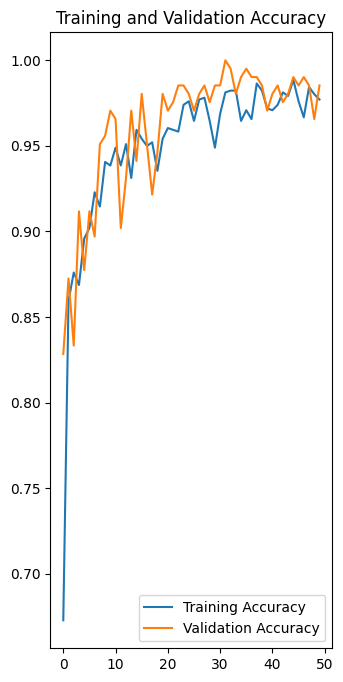

In [51]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Loss')

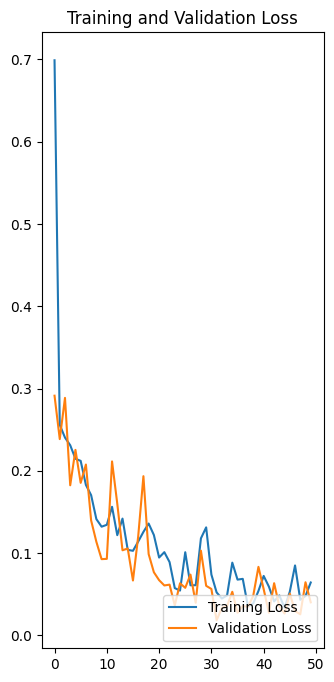

In [52]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

In [53]:
def predict(model, img):
  img_arr = tf.keras.preprocessing.image.img_to_array(img)
  img_arr = tf.expand_dims(img_arr, 0)

  predictions = model.predict(img_arr)

  predicted_class = class_names[np.argmax(predictions)]
  confidence = round(100*(np.max(predictions[0])),2)
  return predicted_class, confidence

1/1 [==============================] - 0s 31ms/step


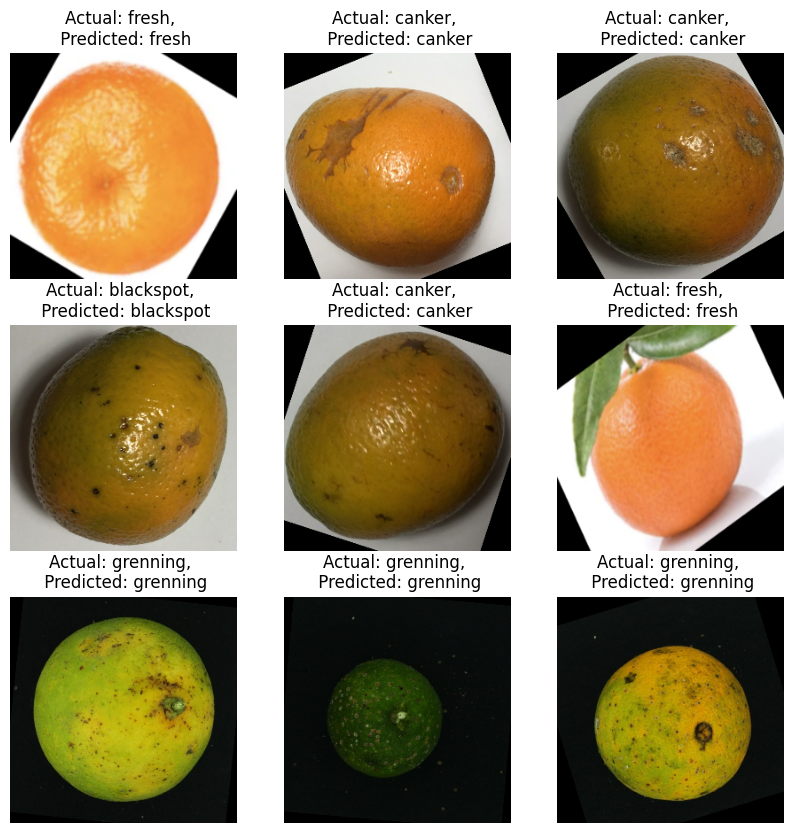

In [55]:
plt.figure(figsize=(10,10))
for images, labels in test_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype('uint8'))

    predicted_class, confidence = predict(model, images[i].numpy())
    actual_class = class_names[labels[i]]

    plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_class}')
    plt.axis('off')

In [61]:
model_versionx = 1
model.save(f'/content/model_{model_versionx}')